In [1]:
import pandas as pd
import joblib
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Load your dataset
df = pd.read_csv("../data/combined_data.csv")

# Convert km/h to m/s
df["v_follower"] = df["Smooth Speed Follower"] * (1000 / 3600)
df["v_leader"] = df["Smooth Speed Leader"] * (1000 / 3600)
df.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader
0,0,2033.00,55.31,55.130,54.9484,55.1524,27.307067,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.263444,15.320111
1,1,2033.02,55.17,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722
2,2,2033.04,55.03,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833
3,3,2033.06,55.04,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611
4,4,2033.08,55.05,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833


In [3]:
# Compute relative speed and spacing
df["delta_v"] = df["v_follower"] - df["v_leader"]
df["spacing"] = df["Spacing"]  # Already in meters

# Estimate time step and acceleration
df["dt"] = df["Time"].diff()
df["acc_follower"] = df["v_follower"].diff() / df["dt"]

# Drop the first row (NaN)
df_cleaned = df.dropna(subset=["dt", "acc_follower"])

df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,delta_v,spacing,dt,acc_follower
1,1,2033.02,55.170,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722,-0.057389,27.315506,0.02,0.144444
2,2,2033.04,55.030,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833,-0.061444,27.323949,0.02,0.052778
3,3,2033.06,55.040,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611,-0.066333,27.319727,0.02,0.044444
4,4,2033.08,55.050,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833,-0.068667,27.315506,0.02,0.094444
5,5,2033.10,55.005,55.340,54.9808,55.2218,27.324214,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.272444,15.339389,-0.066944,27.324214,0.02,0.113889


In [4]:
# Copy the cleaned DataFrame so we can work safely
df_extended = df_cleaned.copy()

# One-hot encode the 'gap_setting' column
gap_dummies = pd.get_dummies(df_extended['gap_setting'], prefix='gap')

# Combine all selected features
features = pd.concat([
    df_extended[["delta_v", "v_follower", "speed_fluctuation","acc_follower"]],
    gap_dummies
], axis=1)

# Keep the same target: spacing
target = df_extended["spacing"]

In [5]:
# Print example rows
features.tail()

,delta_v,v_follower,speed_fluctuation,acc_follower,gap_Long,gap_Medium,gap_Short,gap_XLong
741167,0.088222,26.506778,45,0.050000,False,False,False,True
741168,0.088167,26.507111,45,0.016667,False,False,False,True
741169,0.087778,26.507167,45,0.002778,False,False,False,True
741170,0.089333,26.508556,45,0.069444,False,False,False,True
741171,0.091333,26.509278,45,0.036111,False,False,False,True


In [6]:
target.tail()

741167    62.213738
741168    62.213759
741169    62.213782
741170    62.208222
741171    62.202662
Name: spacing, dtype: float64

In [7]:
import matplotlib.pyplot as plt
# Function to plot relationships between each feature and the target variable (acceleration)
def plot_feature_target_relationships(features, target):
    plt.figure(figsize=(18, 5))

    for i, column in enumerate(features.columns):
        plt.subplot(1, 3, i + 1)
        plt.scatter(features[column], target, alpha=0.4, s=10)
        plt.xlabel(column)
        plt.ylabel("Acceleration (m/s²)")
        plt.title(f"{column} vs Acceleration")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [10]:
# Function to plot feature-target relationships for a specified index range
def plot_feature_target_range(features, target, start=0, end=100):
    plt.figure(figsize=(18, 5))

    # Slice the data for the specified range
    features_range = features.iloc[start:end]
    target_range = target.iloc[start:end]

    for i, column in enumerate(features_range.columns):
        plt.subplot(1, features.shape[1], i + 1)
        plt.scatter(features_range[column], target_range, alpha=0.6, s=20)
        plt.xlabel(column)
        plt.ylabel("Spacing (m/s²)")
        plt.title(f"{column} vs Spacing (Rows {start}–{end})")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

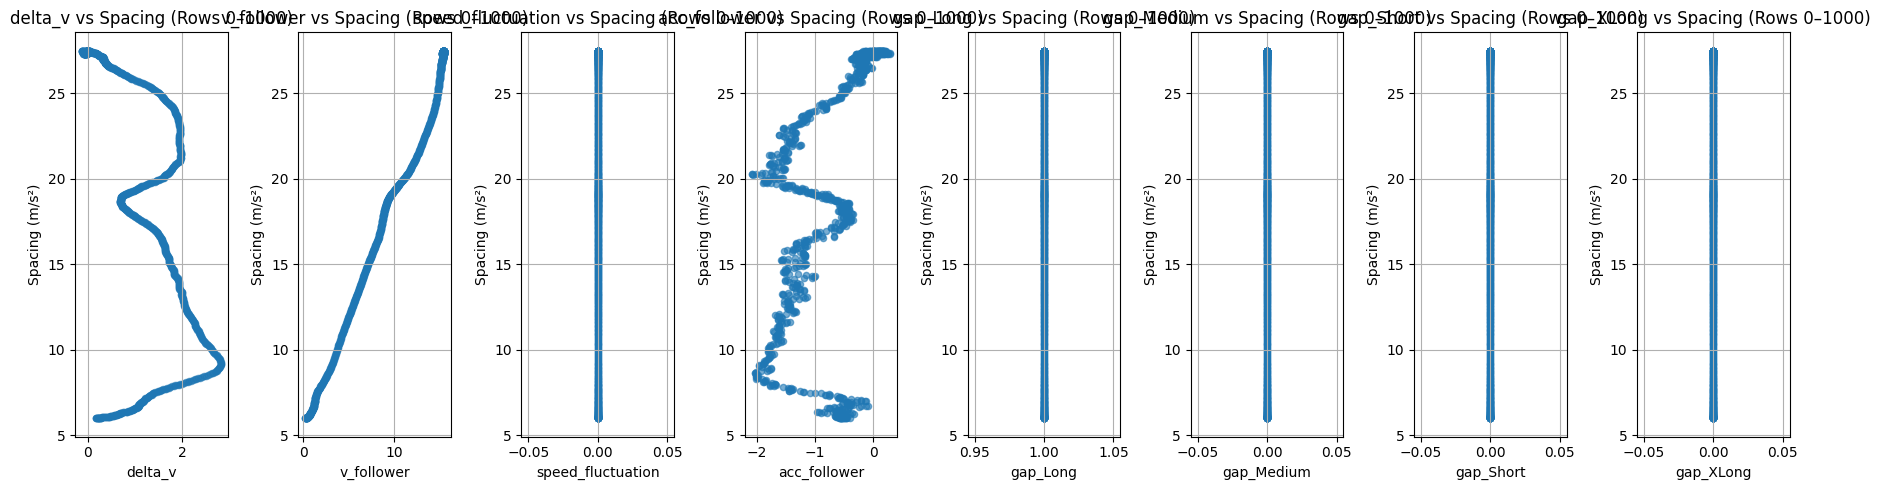

In [11]:
# Example usage: plot only the first 200 data points
plot_feature_target_range(features, target, start=0, end=1000)

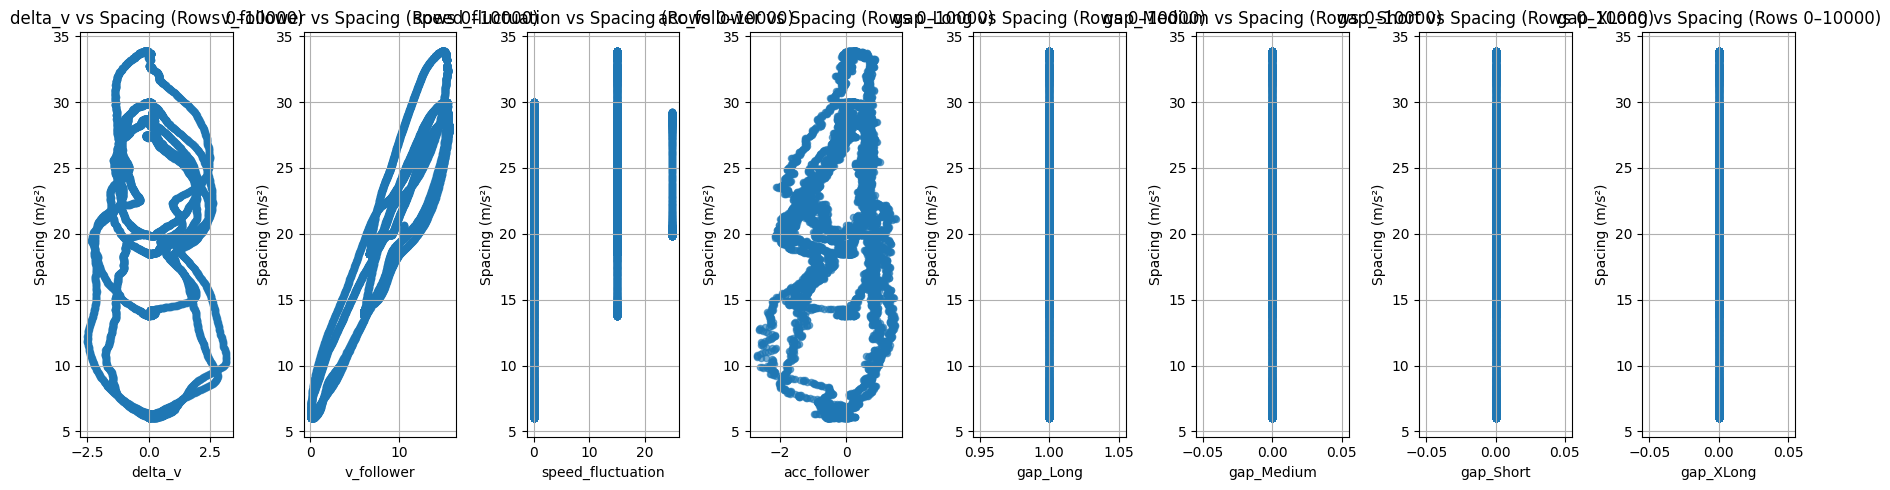

In [12]:
plot_feature_target_range(features, target, start=0, end=10000)

## Train Regression Model

In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# save model
import joblib

# Save the trained model to a file
joblib.dump(rf_model, "rf_model_spacing.pkl")

['rf_model_spacing.pkl']

In [15]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.6837435152218326, 0.9959057295588878)

RMSE = 0.6837 indicates high accuracy in predicting spacing values and an error of less than 1 meter is quite small, especially if your spacing ranges between 5 to 30+ meters.

R² = 0.9959
This is very close to 1, which means model captures almost all the variability in the target




## Predicted vs Actual Spacing

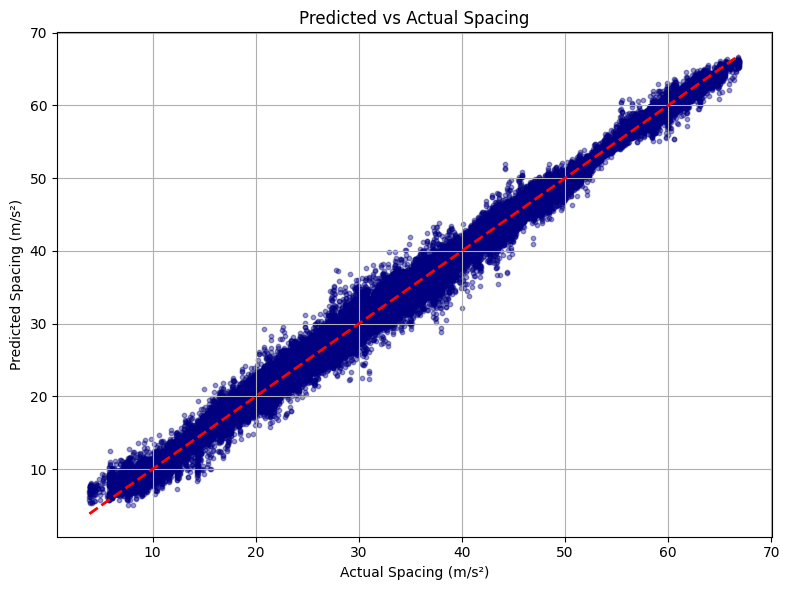

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot predicted vs actual acceleration ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, s=10, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Spacing (m/s²)")
plt.ylabel("Predicted Spacing (m/s²)")
plt.title("Predicted vs Actual Spacing")
plt.grid(True)
plt.tight_layout()
plt.show()

## Residuals Vs Predicted Acceleration

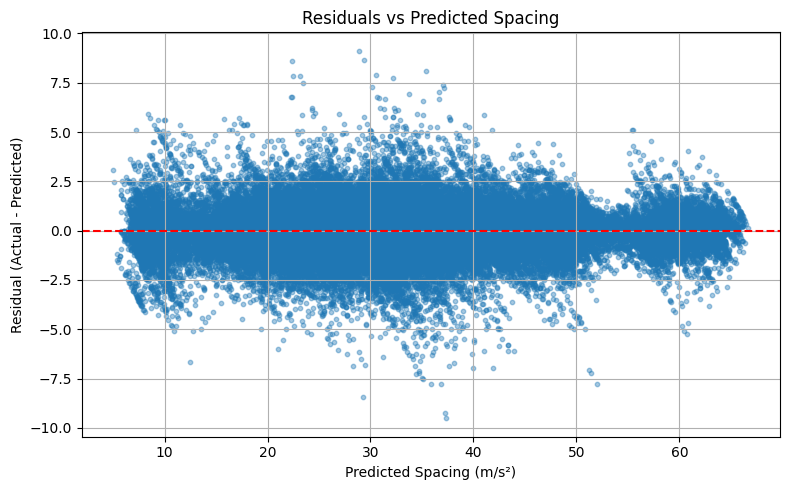

In [18]:
# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Spacing")
plt.xlabel("Predicted Spacing (m/s²)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

Most residuals are tightly clustered around the 0 line → good! Suggests the model is unbiased: it’s not consistently over- or under-predicting.

No skew → the model generalizes evenly across different predicted spacing values.